In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import wandb

# data
import torch
from torchvision.datasets import CIFAR10, CIFAR100, FashionMNIST, Caltech256
import torchvision.transforms as tt
from torch.utils.data.sampler import SubsetRandomSampler

# KNN
from collections import Counter
from scipy.spatial import distance

# SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# CNN

# metric
from sklearn.metrics import accuracy_score, classification_report

# CV
from sklearn.model_selection import ParameterGrid # creates a parameter grid to search for
from sklearn.model_selection import KFold # splits data into k-fold train and valid set


# 0.. data
- CIFAR, fashion MNIST, Caltech-256

In [3]:
random_seed = 2022
valid_size = 0.1

# define transforms

stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))

train_transform = tt.Compose([
    tt.RandomCrop(32, padding=4),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats),
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats),
])

In [4]:
# load data

train_data = CIFAR10(download=True, root="./data", transform=train_transform)
valid_data = CIFAR10(download=True, root="./data", transform=test_transform)
test_data = CIFAR10(download=True, root="./data", transform=test_transform, train=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# split train, valid

num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) 

# shuffle
np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)  # 45000, 5000

In [6]:
def get_data(train_size, valid_size, test_size):
    """
    This function gets you data from DataLoader by iterating one batch.
    :param train_size: number of data points in train set
    :return: X and y for train, valid, test
    """
    print('\n getting dataset... \n')

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=train_size, sampler=train_sampler,
        num_workers=4,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_data, batch_size=valid_size, sampler=valid_sampler,
        num_workers=4,
    )
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=test_size, shuffle=True,
        num_workers=4,
    )

    for batch in train_loader:
        X_train = batch[0].reshape(train_size, -1)  
        y_train = batch[1]
        break
    for batch in valid_loader:
        X_valid = batch[0].reshape(valid_size, -1)
        y_valid = batch[1]
        break
    for batch in test_loader:
        X_test = batch[0].reshape(test_size, -1)
        y_test = batch[1]
        break

    return X_train, y_train, X_valid, y_valid, X_test, y_test



# 1.. KNN

In [6]:
class my_KNN:

    def __init__(self, n_neighbors=3, distance=2):
        self.n_neighbors = n_neighbors
        self.distance = distance

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        pass

    def iterate_X_test(self, X_test):

        y_pred = torch.stack([self.predict_x_test(x_test)
                             for x_test in X_test])

        return y_pred

    def predict_x_test(self, x_test):

        if self.distance == 2: # L2 distance
            distance_list = [
                np.linalg.norm(x_test-x_train) for x_train in self.X_train
            ]
        elif self.distance == 1: # L1 distance
            distance_list = [
                distance.cityblock(x_test, x_train) for x_train in self.X_train
            ]
        elif self.distance == 3: # minkowski distance
            distance_list = [
                distance.minkowski(x_test, x_train) for x_train in self.X_train
            ]

        distance_indices = np.argsort(distance_list)  # indices from min to max

        top_k_labels = [
            self.y_train[i] for i in distance_indices[:self.n_neighbors]
        ]

        voted_label = Counter(top_k_labels).most_common(1)[0][0]

        return voted_label


## A. Runtime & Accuracy

In [7]:
wandb.init(project="AML-CW-1", entity="youngandbin")
wandb.config = {
    "model_name": 'KNN',
    "train_size": [1000, 2000, 3000, 4000]
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: youngandbin (use `wandb login --relogin` to force relogin)


In [8]:
for train_size in tqdm(wandb.config['train_size']):

    X_train, y_train, X_valid, y_valid, X_test, y_test = get_data(train_size, 100, 100)

    model = my_KNN(n_neighbors=3, distance=1)
    # train
    start_time = datetime.now()
    model.fit(X_train, y_train)
    time_train = datetime.now() - start_time
    # test
    start_time = datetime.now()
    y_pred = model.iterate_X_test(X_test)
    time_test = datetime.now() - start_time
    # runtime, accuracy
    wandb.log({'Runtime (Train)': time_train.microseconds,
               'Runtime (Test)': time_test.microseconds,
                'Accuracy': accuracy_score(y_test, y_pred)})
    print(f'acc: {accuracy_score(y_test, y_pred)}')


  0%|          | 0/4 [00:00<?, ?it/s]


 getting dataset... 



 25%|██▌       | 1/4 [00:24<01:12, 24.11s/it]

acc: 0.31

 getting dataset... 



 50%|█████     | 2/4 [00:49<00:50, 25.12s/it]

acc: 0.27

 getting dataset... 



 75%|███████▌  | 3/4 [01:17<00:26, 26.11s/it]

acc: 0.25

 getting dataset... 



100%|██████████| 4/4 [01:46<00:00, 26.60s/it]

acc: 0.21


## B. Hyperparameters
1) n_neighbors (number of neighbors)
    - np.arange(5,N,5) 
        - N: number of dataset
    - 이웃을 많이 사용할 수록 복잡도가 낮아짐 (결정 경계가 부드러워짐)
        - 머신러닝 책 p67
2) distance (distance metric)
    - L1, L2, minkowski

In [9]:
def validate_model(hyperparams, dataset, CV=True):

    X_train, y_train, X_valid, y_valid, X_test, y_test = dataset

    # assign hyperparams
    param_1, param_2 = hyperparams
    
    if CV == True:
        # initialize final results
        y_pred_list = []; y_valid_list = []
        # cross-validation
        X, y = X_train, y_train
        kf = KFold(n_splits=5, shuffle=True, random_state=2022)
        for train_idx, valid_idx in kf.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            # model
            model = my_KNN(n_neighbors=param_1, distance=param_2)
            model.fit(X_train, y_train)
            y_pred = model.iterate_X_test(X_valid) 
            y_pred_list.append(y_pred)
            y_valid_list.append(y_valid)
        # flatten list: number of predictions = train_size = train_size/n_splits * n_splits
        y_pred_list = [item for sublist in y_pred_list for item in sublist]
        y_valid_list = [item for sublist in y_valid_list for item in sublist]
        # calculate acc metric
        acc = accuracy_score(y_valid_list, y_pred_list)
    else:
        # model
        model = my_KNN(n_neighbors=param_1, distance=param_2)
        model.fit(X_train, y_train)
        y_pred = model.iterate_X_test(X_valid) 
        # calculate acc metric
        acc = accuracy_score(y_pred, y_valid)

    return acc


In [10]:
def create_hyperparams_grid(param_grid, model_params):
    graph_x = []; graph_y = []; graph_z = []
    for param_1 in tqdm(param_grid['param_1']):
        graph_x_row = []; graph_y_row = []; graph_z_row = []
        for param_2 in param_grid['param_2']:
            hyperparams = (param_1, param_2)
            acc = validate_model(hyperparams, model_params['dataset'], model_params['CV'])
            graph_x_row.append(param_1)
            graph_y_row.append(param_2)
            graph_z_row.append(acc)
        graph_x.append(graph_x_row)
        graph_y.append(graph_y_row)
        graph_z.append(graph_z_row)
        print('')
    graph_x=np.array(graph_x)
    graph_y=np.array(graph_y)
    graph_z=np.array(graph_z)
    max_z = np.max(graph_z)
    pos_max_z = np.argwhere(graph_z == np.max(graph_z))[0]
    print('Maximum Accuracy: %.4f' %(max_z))
    print('Optimum %s: %f' % (param_grid['names']['param_1'], graph_x[pos_max_z[0], pos_max_z[1]]))
    print('Optimum %s: %f' % (param_grid['names']['param_2'], graph_y[pos_max_z[0], pos_max_z[1]]))
    best_params = {'param_1': graph_x[pos_max_z[0], pos_max_z[1]],
                   'param_2': graph_y[pos_max_z[0], pos_max_z[1]]}
    return graph_x,graph_y,graph_z, best_params

In [11]:
def plot_hyperparams_grid(graph_x, graph_y, graph_z, param_grid):
    size_list=np.array(graph_z)
    size_list=30/(size_list)**2
    points=plt.scatter(graph_x, graph_y, c=graph_z, cmap='viridis', 
                       vmin=np.min(graph_z), vmax=np.max(graph_z), marker='o', s=size_list)
    cbar=plt.colorbar(points)
    cbar.set_label("$Accuracy$", fontsize=14)
    # plt.xlabel(r'${}$'.fotmat(param_grid['names']['param_1']), fontsize=14)
    # plt.ylabel(r'${}$'.fotmat(param_grid['names']['param_2']), fontsize=14)
    plt.xlabel(param_grid['names']['param_1'], fontsize=14)
    plt.ylabel(param_grid['names']['param_2'], fontsize=14)
    plt.yticks(graph_y[0])
    file_name = 'Figure_hyperparams_grid.png'
    plt.savefig(file_name,format='png',dpi=600)
    plt.show()
    #plt.close()

In [12]:
def main():
    # Create hyperparams grid
    graph_x, graph_y, graph_z, best_params = create_hyperparams_grid(param_grid, model_params)
    # Plot hyperparams_grid
    plot_hyperparams_grid(graph_x,graph_y,graph_z, param_grid)

    return best_params


 getting dataset... 



 33%|███▎      | 1/3 [00:04<00:08,  4.07s/it]

 67%|██████▋   | 2/3 [00:08<00:04,  4.06s/it]

100%|██████████| 3/3 [00:12<00:00,  4.04s/it]


Maximum Accuracy: 0.2000
Optimum n_neighbors: 3.000000
Optimum distance: 1.000000


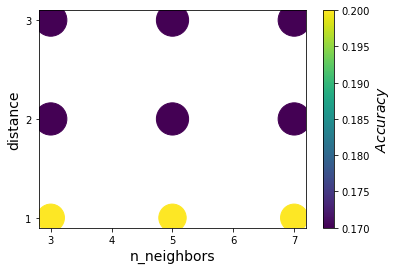

In [13]:
# validation

dataset = (get_data(train_size=1000, valid_size=100, test_size=100))  # tuple
param_grid = {'param_1': [3, 5, 7],
              'param_2': [1, 2, 3],
              'names':{'param_1':'n_neighbors', 'param_2':'distance'}}
model_params = {'dataset': dataset, 'CV': False}
best_params_V = main()

 33%|███▎      | 1/3 [00:33<01:06, 33.48s/it]

 67%|██████▋   | 2/3 [01:06<00:33, 33.33s/it]

100%|██████████| 3/3 [01:39<00:00, 33.33s/it]


Maximum Accuracy: 0.1920
Optimum n_neighbors: 3.000000
Optimum distance: 1.000000


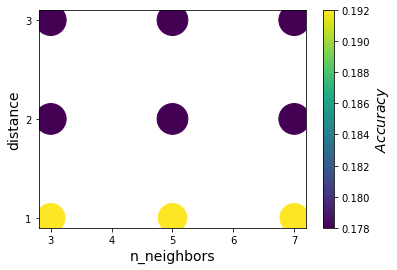

In [14]:
# cross-validation

model_params['CV'] = True
best_params_CV = main()


In [15]:
# final test

X_train, y_train, X_valid, y_valid, X_test, y_test = dataset


# validation
model = my_KNN(n_neighbors=best_params_V['param_1'], distance=best_params_V['param_2'])
model.fit(X_train, y_train)
y_pred = model.iterate_X_test(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')

# cross-validation
model = my_KNN(n_neighbors=best_params_CV['param_1'], distance=best_params_CV['param_2'])
model.fit(X_train, y_train)
y_pred = model.iterate_X_test(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')

acc: 0.16
acc: 0.16


# 2.. SVM

## A. Runtime & Accuracy

In [16]:
wandb.init(project="AML-CW-1", entity="youngandbin")
wandb.config = {
    "model_name": 'SVM linear',
    "train_size": [1000, 2000, 3000, 4000]
}

Accuracy,█▅▄▁
Runtime (Test),▁▃▆█
Runtime (Train),▁▁▁▁
Accuracy,0.21
Runtime (Test),963891
Runtime (Train),0


In [17]:
for train_size in tqdm(wandb.config['train_size']):

    X_train, y_train, X_valid, y_valid, X_test, y_test = get_data(train_size, 100, 100)

    model = SVC(kernel='linear')
    # train
    start_time = datetime.now()
    model.fit(X_train, y_train)
    time_train = datetime.now()-start_time
    # test
    start_time = datetime.now()
    y_pred = model.predict(X_test)
    time_test = datetime.now()-start_time
    # runtime, accuracy
    wandb.log({'Runtime (Train)': time_train.microseconds,
               'Runtime (Test)': time_test.microseconds,
                'Accuracy': accuracy_score(y_test, y_pred)})
    print(f'acc: {accuracy_score(y_test, y_pred)}')

  0%|          | 0/4 [00:00<?, ?it/s]


 getting dataset... 



 25%|██▌       | 1/4 [00:23<01:10, 23.66s/it]

acc: 0.24

 getting dataset... 



 50%|█████     | 2/4 [00:50<00:50, 25.49s/it]

acc: 0.25

 getting dataset... 



 75%|███████▌  | 3/4 [01:26<00:30, 30.48s/it]

acc: 0.29

 getting dataset... 



100%|██████████| 4/4 [02:22<00:00, 35.53s/it]

acc: 0.3


In [18]:
wandb.init(project="AML-CW-1", entity="youngandbin")
wandb.config = {
    "model_name": 'SVM nonlinear',
    "train_size": [1000, 2000, 3000, 4000]
}

Accuracy,▁▂▇█
Runtime (Test),▁▄▆█
Runtime (Train),█▆▄▁
Accuracy,0.3
Runtime (Test),501453
Runtime (Train),40648


In [19]:
for train_size in tqdm(wandb.config['train_size']):

    X_train, y_train, X_valid, y_valid, X_test, y_test = get_data(train_size, 100, 100)

    model = SVC(kernel='rbf')
    # train
    start_time = datetime.now()
    model.fit(X_train, y_train)
    time_train = datetime.now()-start_time
    # test
    start_time = datetime.now()
    y_pred = model.predict(X_test)
    time_test = datetime.now()-start_time
    # runtime, accuracy
    wandb.log({'Runtime (Train)': time_train.microseconds,
               'Runtime (Test)': time_test.microseconds,
               'Accuracy': accuracy_score(y_test, y_pred)})
    print(f'acc: {accuracy_score(y_test, y_pred)}')


  0%|          | 0/4 [00:00<?, ?it/s]


 getting dataset... 



 25%|██▌       | 1/4 [00:23<01:10, 23.35s/it]

acc: 0.28

 getting dataset... 



 50%|█████     | 2/4 [00:49<00:50, 25.17s/it]

acc: 0.32

 getting dataset... 



 75%|███████▌  | 3/4 [01:26<00:30, 30.24s/it]

acc: 0.38

 getting dataset... 



100%|██████████| 4/4 [02:19<00:00, 34.79s/it]

acc: 0.4


## B. Hyperparameters
[linear]
1. C
    - 10 ~ 30000

[nonlinear]
1. C
    - 1 ~ 1000
2. gamma
    - 0.01 ~ 3

In [20]:
param_grid = [
    {'kernel': ['linear'], 'C': [10., 30., 100.]},
    {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.],
                        'gamma': [0.01, 0.03, 0.1]},
]

### (1) linear

In [21]:
def validate_model_SVM_linear(hyperparams, dataset, CV=True):

    X_train, y_train, X_valid, y_valid, X_test, y_test = dataset

    # assign hyperparams
    param_1, param_2 = hyperparams

    if CV == True:
        # initialize final results
        y_pred_list = []
        y_valid_list = []
        # cross-validation
        X, y = X_train, y_train
        kf = KFold(n_splits=5, shuffle=True, random_state=2022)
        for train_idx, valid_idx in kf.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            # model
            model = SVC(C=param_1, kernel='linear')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_valid)
            y_pred_list.append(y_pred)
            y_valid_list.append(y_valid)
        # flatten list: number of predictions = train_size = train_size/n_splits * n_splits
        y_pred_list = [item for sublist in y_pred_list for item in sublist]
        y_valid_list = [item for sublist in y_valid_list for item in sublist]
        # calculate acc metric
        acc = accuracy_score(y_valid_list, y_pred_list)
    else:
        # model
        model = SVC(C=param_1, kernel='linear')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        # calculate acc metric
        acc = accuracy_score(y_pred, y_valid)

    return acc

In [22]:
def create_hyperparams_grid(param_grid, model_params):
    graph_x = []; graph_y = []; graph_z = []
    for param_1 in param_grid['param_1']:
        graph_x_row = []; graph_y_row = []; graph_z_row = []
        for param_2 in param_grid['param_2']:
            hyperparams = (param_1, param_2)
            acc = validate_model_SVM_linear(hyperparams, model_params['dataset'], model_params['CV'])
            graph_x_row.append(param_1)
            graph_y_row.append(param_2)
            graph_z_row.append(acc)
        graph_x.append(graph_x_row)
        graph_y.append(graph_y_row)
        graph_z.append(graph_z_row)
        print('')
    graph_x=np.array(graph_x)
    graph_y=np.array(graph_y)
    graph_z=np.array(graph_z)
    max_z = np.max(graph_z)
    pos_max_z = np.argwhere(graph_z == np.max(graph_z))[0]
    print('Maximum Accuracy: %.4f' %(max_z))
    print('Optimum %s: %f' % (param_grid['names']['param_1'], graph_x[pos_max_z[0], pos_max_z[1]]))
    print('Optimum %s: %f' % (param_grid['names']['param_2'], graph_y[pos_max_z[0], pos_max_z[1]]))
    best_params = {'param_1': graph_x[pos_max_z[0], pos_max_z[1]],
                   'param_2': graph_y[pos_max_z[0], pos_max_z[1]]}
    return graph_x,graph_y,graph_z, best_params


 getting dataset... 




Maximum Accuracy: 0.2500
Optimum C: 1.000000
Optimum kernel: 1.000000


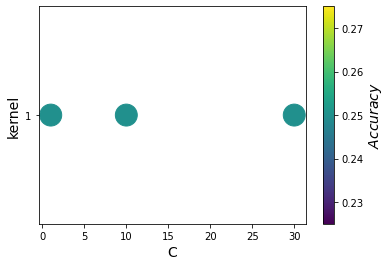

In [23]:
# validation

dataset = (get_data(train_size=1000, valid_size=100, test_size=100))  # tuple
param_grid = {'param_1': [1., 10., 30.],
              'param_2': [1],
              'names':{'param_1':'C', 'param_2':'kernel'}}
model_params = {'dataset': dataset, 'CV': False}
best_params_V = main()




Maximum Accuracy: 0.2360
Optimum C: 1.000000
Optimum kernel: 1.000000


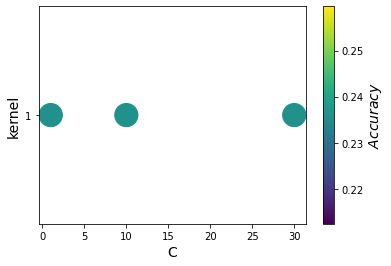

In [24]:
# cross-validation

model_params['CV'] = True
best_params_CV = main()


In [25]:
# final test

X_train, y_train, X_valid, y_valid, X_test, y_test = dataset

# validation
model = SVC(C=best_params_V['param_1'], kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')

# cross-validation
model = SVC(C=best_params_CV['param_1'], kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')

acc: 0.33
acc: 0.33


### (2) nonlinear

In [40]:
def validate_model_SVM_nonlinear(hyperparams, dataset, CV=True):

    X_train, y_train, X_valid, y_valid, X_test, y_test = dataset

    # assign hyperparams
    param_1, param_2 = hyperparams

    if CV == True:
        # initialize final results
        y_pred_list = []
        y_valid_list = []
        # cross-validation
        X, y = X_train, y_train
        kf = KFold(n_splits=5, shuffle=True, random_state=2022)
        for train_idx, valid_idx in kf.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            # model
            model = SVC(C=param_1, gamma=param_2, kernel='rbf')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_valid)
            y_pred_list.append(y_pred)
            y_valid_list.append(y_valid)
        # flatten list: number of predictions = train_size = train_size/n_splits * n_splits
        y_pred_list = [item for sublist in y_pred_list for item in sublist]
        y_valid_list = [item for sublist in y_valid_list for item in sublist]
        # calculate acc metric
        acc = accuracy_score(y_valid_list, y_pred_list)
    else:
        # model
        model = SVC(C=param_1, gamma=param_2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        # calculate acc metric
        acc = accuracy_score(y_pred, y_valid)

    return acc


In [41]:
def create_hyperparams_grid(param_grid, model_params):
    graph_x = []; graph_y = []; graph_z = []
    for param_1 in param_grid['param_1']:
        graph_x_row = []; graph_y_row = []; graph_z_row = []
        for param_2 in param_grid['param_2']:
            hyperparams = (param_1, param_2)
            acc = validate_model_SVM_nonlinear(hyperparams, model_params['dataset'], model_params['CV'])
            graph_x_row.append(param_1)
            graph_y_row.append(param_2)
            graph_z_row.append(acc)
        graph_x.append(graph_x_row)
        graph_y.append(graph_y_row)
        graph_z.append(graph_z_row)
        print('')
    graph_x=np.array(graph_x)
    graph_y=np.array(graph_y)
    graph_z=np.array(graph_z)
    max_z = np.max(graph_z)
    pos_max_z = np.argwhere(graph_z == np.max(graph_z))[0]
    print('Maximum Accuracy: %.4f' %(max_z))
    print('Optimum %s: %f' % (param_grid['names']['param_1'], graph_x[pos_max_z[0], pos_max_z[1]]))
    print('Optimum %s: %f' % (param_grid['names']['param_2'], graph_y[pos_max_z[0], pos_max_z[1]]))
    best_params = {'param_1': graph_x[pos_max_z[0], pos_max_z[1]],
                   'param_2': graph_y[pos_max_z[0], pos_max_z[1]]}
    return graph_x,graph_y,graph_z, best_params


 getting dataset... 




Maximum Accuracy: 0.3800
Optimum C: 10.000000
Optimum gamma: 0.000100


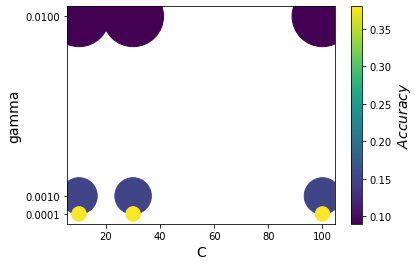

In [42]:
# validation

dataset = (get_data(train_size=1000, valid_size=100, test_size=100))  # tuple
param_grid = {'param_1': [10, 30, 100.],
              'param_2': [0.01, 0.001, 0.0001],
              'names': {'param_1': 'C', 'param_2': 'gamma'}}
model_params = {'dataset': dataset, 'CV': False}
best_params_V = main()





Maximum Accuracy: 0.2530
Optimum C: 30.000000
Optimum gamma: 0.000100


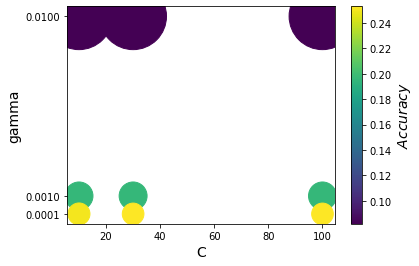

In [43]:
# cross-validation

model_params['CV'] = True
best_params_CV = main()


In [44]:
# final test

X_train, y_train, X_valid, y_valid, X_test, y_test = dataset

# validation
model = SVC(C=best_params_V['param_1'], gamma=best_params_V['param_2'], kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')

# cross-validation
model = SVC(C=best_params_CV['param_1'], gamma=best_params_CV['param_2'], kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')


acc: 0.31
acc: 0.33


# 3.. Decision Tree

In [7]:
def GINI_impurity(labels):
    nums = [i[1] for i in Counter(labels).items()] # number of samples for each label
    impurity = 1 - np.sum(list(map(lambda x: np.square(x/np.sum(nums)), nums)))
    return impurity

In [8]:
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, y_pred=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.y_pred = y_pred

    def is_leaf_node(self):
        """
        if 'y_pred' exists, the node is a leaf node
        """
        return self.y_pred is not None

class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
    
    def fit(self, X, y):
        # if n_feats not specified, it will go through all features in greedy_search
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)
        
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape

        # stop and return a leaf node with y_pred
        if depth >= self.max_depth:
            return Node(y_pred = np.bincount(y).argmax())
        if n_samples < self.min_samples_split:
            return Node(y_pred = np.bincount(y).argmax())
        if len(np.unique(y)) == 1:# when there is only 1 label left
            return Node(y_pred = np.bincount(y).argmax())

        # random forest

        indices = np.random.choice(n_features, self.n_feats, replace=False)
        best_feature, best_split = self._greedy_search(X, y, indices)   
        # split tree 
        left_idxs, right_idxs = np.argwhere(X[:, best_feature] <= best_split).flatten(), np.argwhere(X[:, best_feature] > best_split).flatten()
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)

        return Node(best_feature, best_split, left, right)
        
    def _greedy_search(self, X, y, indices):
        """
        loop over features to find the best feature and best split
        """
        best_gain = -1
        for i in indices:
            X_i = X[:, i] # one feature
            thresholds = np.unique(X_i)
            for t in thresholds:
                gain = self._information_gain(y, X_i, t)
                if gain > best_gain:
                    best_gain = gain
                    feature = i
                    split = t
        return feature, split

    def _information_gain(self, y, X_i, split):
        # parent impurity
        parent_impurity = GINI_impurity(y)
        # child impurity (weighted avg)
        left_idxs, right_idxs = np.argwhere(X_i <= split).flatten(), np.argwhere(X_i > split).flatten()
        n_total, n_left, n_right = len(y), len(left_idxs), len(right_idxs)
        child_impurity = (n_left/n_total)*GINI_impurity(y[left_idxs]) + (n_right/n_total)*GINI_impurity(y[right_idxs])
        # information gain
        return parent_impurity - child_impurity

    
    def predict(self, X):
        # traverse tree
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.y_pred
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

## A. Runtime & Accuracy

In [47]:
wandb.init(project="AML-CW-1", entity="youngandbin")
wandb.config = {
    "model_name": 'Decision Tree',
    "train_size": [1000, 1500, 2000]
}


Accuracy,▁▃▇█
Runtime (Test),▁▃▅█
Runtime (Train),▇▁█▃
Accuracy,0.4
Runtime (Test),795797
Runtime (Train),338104


In [48]:
for train_size in tqdm(wandb.config['train_size']):

    X_train, y_train, X_valid, y_valid, X_test, y_test = get_data(train_size, 100, 100)

    model = DecisionTree(min_samples_split=100, max_depth=3, n_feats=10)
    # train
    start_time = datetime.now()
    model.fit(X_train, y_train)
    time_train = datetime.now()-start_time
    # test
    start_time = datetime.now()
    y_pred = model.predict(X_test)
    time_test = datetime.now()-start_time
    # runtime, accuracy
    wandb.log({'Runtime (Train)': time_train.microseconds,
               'Runtime (Test)': time_test.microseconds,
                'Accuracy': accuracy_score(y_test, y_pred)})
    print(f'acc: {accuracy_score(y_test, y_pred)}')

  0%|          | 0/3 [00:00<?, ?it/s]


 getting dataset... 



 33%|███▎      | 1/3 [10:22<20:44, 622.47s/it]

acc: 0.06

 getting dataset... 



 67%|██████▋   | 2/3 [47:49<26:18, 1578.26s/it]

acc: 0.04

 getting dataset... 



100%|██████████| 3/3 [1:29:10<00:00, 1783.37s/it]

acc: 0.07


## B. Hyperparameters

In [49]:
def validate_model_DT(hyperparams, dataset, CV=True):

    X_train, y_train, X_valid, y_valid, X_test, y_test = dataset

    # assign hyperparams
    param_1, param_2 = hyperparams

    if CV == True:
        # initialize final results
        y_pred_list = []
        y_valid_list = []
        # cross-validation
        X, y = X_train, y_train
        kf = KFold(n_splits=5, shuffle=True, random_state=2022)
        for train_idx, valid_idx in kf.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            # model
            model = DecisionTree(min_samples_split=param_1, max_depth=param_2, n_feats=10)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_valid)
            y_pred_list.append(y_pred)
            y_valid_list.append(y_valid)
        # flatten list: number of predictions = train_size = train_size/n_splits * n_splits
        y_pred_list = [item for sublist in y_pred_list for item in sublist]
        y_valid_list = [item for sublist in y_valid_list for item in sublist]
        # calculate acc metric
        acc = accuracy_score(y_valid_list, y_pred_list)
    else:
        # model
        model = DecisionTree(min_samples_split=param_1, max_depth=param_2, n_feats=10)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        # calculate acc metric
        acc = accuracy_score(y_pred, y_valid)

    return acc


In [50]:
def create_hyperparams_grid(param_grid, model_params):
    graph_x = []; graph_y = []; graph_z = []
    for param_1 in param_grid['param_1']:
        graph_x_row = []; graph_y_row = []; graph_z_row = []
        for param_2 in param_grid['param_2']:
            hyperparams = (param_1, param_2)
            acc = validate_model_DT(hyperparams, model_params['dataset'], model_params['CV'])
            graph_x_row.append(param_1)
            graph_y_row.append(param_2)
            graph_z_row.append(acc)
        graph_x.append(graph_x_row)
        graph_y.append(graph_y_row)
        graph_z.append(graph_z_row)
        print('')
    graph_x=np.array(graph_x)
    graph_y=np.array(graph_y)
    graph_z=np.array(graph_z)
    max_z = np.max(graph_z)
    pos_max_z = np.argwhere(graph_z == np.max(graph_z))[0]
    print('Maximum Accuracy: %.4f' %(max_z))
    print('Optimum %s: %f' % (param_grid['names']['param_1'], graph_x[pos_max_z[0], pos_max_z[1]]))
    print('Optimum %s: %f' % (param_grid['names']['param_2'], graph_y[pos_max_z[0], pos_max_z[1]]))
    best_params = {'param_1': graph_x[pos_max_z[0], pos_max_z[1]],
                   'param_2': graph_y[pos_max_z[0], pos_max_z[1]]}
    return graph_x,graph_y,graph_z, best_params


 getting dataset... 



Maximum Accuracy: 0.2000
Optimum min_samples_split: 100.000000
Optimum max_depth: 3.000000


C:\Users\YOUNGBIN\AppData\Local\Temp\ipykernel_29620\3137371350.py:3: RuntimeWarning: divide by zero encountered in true_divide
  size_list=30/(size_list)**2


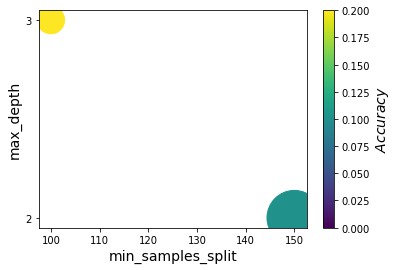

In [52]:
# validation

dataset = (get_data(train_size=500, valid_size=10, test_size=10))  # tuple
param_grid = {'param_1': [100, 150],
              'param_2': [3, 2],
              'names': {'param_1': 'min_samples_split', 'param_2': 'max_depth'}}
model_params = {'dataset': dataset, 'CV': False}
best_params_V = main()




Maximum Accuracy: 0.1280
Optimum min_samples_split: 100.000000
Optimum max_depth: 2.000000


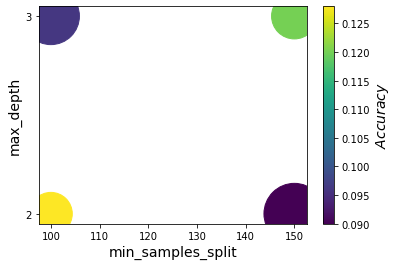

In [53]:
# cross-validation

model_params['CV'] = True
best_params_CV = main()


In [59]:
# final test

X_train, y_train, X_valid, y_valid, X_test, y_test = get_data(train_size=500, valid_size=50, test_size=50)

# validation
model = DecisionTree(min_samples_split=best_params_V['param_1'], max_depth=best_params_V['param_2'], n_feats=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')

# cross-validation
model = DecisionTree(min_samples_split=best_params_CV['param_1'], max_depth=best_params_CV['param_2'], n_feats=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')



 getting dataset... 

acc: 0.16
acc: 0.08


# 4.. Random Forest

In [9]:
def bootstrapping(X, y):
    indices = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
    return X[indices], y[indices]

In [10]:
class RandomForest: 

    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.forest = []

    def fit(self, X, y):
        self.forest = []
        for t in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                                max_depth=self.max_depth, n_feats=self.n_feats)
            X_s, y_s = bootstrapping(X, y)
            tree.fit(X_s, y_s)
            self.forest.append(tree)

    def predict(self, X):
        forest_preds = np.array([tree.predict(X) for tree in self.forest])
        # majority vote
        forest_preds = np.swapaxes(forest_preds, 0, 1)
        y_pred = np.array([np.bincount(pred).argmax()
                          for pred in forest_preds])
        return y_pred


In [11]:
# test run

X_train, y_train, X_valid, y_valid, X_test, y_test = get_data(train_size=500, valid_size=50, test_size=50)

# model
model = RandomForest(n_trees=2, min_samples_split=100, max_depth=2, n_feats=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# calculate acc metric
acc = accuracy_score(y_pred, y_test)
acc



 getting dataset... 



0.02

## A. Runtime & Accuracy

In [62]:
wandb.init(project="AML-CW-1", entity="youngandbin")
wandb.config = {
    "model_name": 'Random Forest',
    "train_size": [500, 600, 700]
}

Accuracy,▆▁█
Runtime (Test),██▁
Runtime (Train),█▃▁
Accuracy,0.07
Runtime (Test),3003
Runtime (Train),112440


In [63]:
for train_size in tqdm(wandb.config['train_size']):

    X_train, y_train, X_valid, y_valid, X_test, y_test = get_data(train_size, 50, 50)

    model = RandomForest(n_trees=2, min_samples_split=10, max_depth=3, n_feats=5)
    # train
    start_time = datetime.now()
    model.fit(X_train, y_train)
    time_train = datetime.now()-start_time
    # test
    start_time = datetime.now()
    y_pred = model.predict(X_test)
    time_test = datetime.now()-start_time
    # runtime, accuracy
    wandb.log({'Runtime (Train)': time_train.microseconds,
               'Runtime (Test)': time_test.microseconds,
                'Accuracy': accuracy_score(y_test, y_pred)})
    print(f'acc: {accuracy_score(y_test, y_pred)}')

  0%|          | 0/3 [00:00<?, ?it/s]


 getting dataset... 



 33%|███▎      | 1/3 [03:27<06:54, 207.39s/it]

acc: 0.14

 getting dataset... 



 67%|██████▋   | 2/3 [07:45<03:57, 237.27s/it]

acc: 0.22

 getting dataset... 



100%|██████████| 3/3 [13:25<00:00, 268.44s/it]

acc: 0.04


## B. Hyperparameters

In [64]:
def validate_model_RF(hyperparams, dataset, CV=True):

    X_train, y_train, X_valid, y_valid, X_test, y_test = dataset

    # assign hyperparams
    param_1, param_2 = hyperparams

    if CV == True:
        # initialize final results
        y_pred_list = []
        y_valid_list = []
        # cross-validation
        X, y = X_train, y_train
        kf = KFold(n_splits=5, shuffle=True, random_state=2022)
        for train_idx, valid_idx in kf.split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            # model
            model = RandomForest(n_trees=2, min_samples_split=param_1, max_depth=param_2, n_feats=5)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_valid)
            y_pred_list.append(y_pred)
            y_valid_list.append(y_valid)
        # flatten list: number of predictions = train_size = train_size/n_splits * n_splits
        y_pred_list = [item for sublist in y_pred_list for item in sublist]
        y_valid_list = [item for sublist in y_valid_list for item in sublist]
        # calculate acc metric
        acc = accuracy_score(y_valid_list, y_pred_list)
    else:
        # model
        model = RandomForest(n_trees=2, min_samples_split=param_1, max_depth=param_2, n_feats=5)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        # calculate acc metric
        acc = accuracy_score(y_pred, y_valid)

    return acc


In [65]:
def create_hyperparams_grid(param_grid, model_params):
    graph_x = []; graph_y = []; graph_z = []
    for param_1 in param_grid['param_1']:
        graph_x_row = []; graph_y_row = []; graph_z_row = []
        for param_2 in param_grid['param_2']:
            hyperparams = (param_1, param_2)
            acc = validate_model_RF(hyperparams, model_params['dataset'], model_params['CV'])
            graph_x_row.append(param_1)
            graph_y_row.append(param_2)
            graph_z_row.append(acc)
        graph_x.append(graph_x_row)
        graph_y.append(graph_y_row)
        graph_z.append(graph_z_row)
        print('')
    graph_x=np.array(graph_x)
    graph_y=np.array(graph_y)
    graph_z=np.array(graph_z)
    max_z = np.max(graph_z)
    pos_max_z = np.argwhere(graph_z == np.max(graph_z))[0]
    print('Maximum Accuracy: %.4f' %(max_z))
    print('Optimum %s: %f' % (param_grid['names']['param_1'], graph_x[pos_max_z[0], pos_max_z[1]]))
    print('Optimum %s: %f' % (param_grid['names']['param_2'], graph_y[pos_max_z[0], pos_max_z[1]]))
    best_params = {'param_1': graph_x[pos_max_z[0], pos_max_z[1]],
                   'param_2': graph_y[pos_max_z[0], pos_max_z[1]]}
    return graph_x,graph_y,graph_z, best_params


 getting dataset... 




C:\Users\YOUNGBIN\AppData\Local\Temp\ipykernel_29620\3137371350.py:3: RuntimeWarning: divide by zero encountered in true_divide
  size_list=30/(size_list)**2
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001F0F9023310>
Traceback (most recent call last):
  File "C:\Users\YOUNGBIN\anaconda3\envs\AML\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "C:\Users\YOUNGBIN\anaconda3\envs\AML\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'



Maximum Accuracy: 0.2000
Optimum min_samples_split: 100.000000
Optimum max_depth: 2.000000


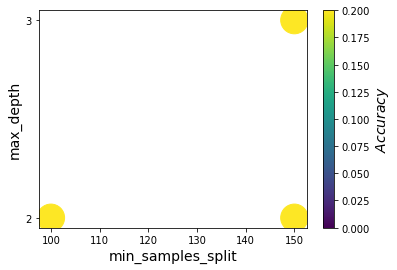

In [67]:
# validation

dataset = (get_data(train_size=500, valid_size=10, test_size=10))  # tuple

param_grid = {'param_1': [100, 150],
              'param_2': [2, 3],
              'names': {'param_1': 'min_samples_split', 'param_2': 'max_depth'}}
model_params = {'dataset': dataset, 'CV': False}
best_params_V = main()




Maximum Accuracy: 0.1200
Optimum min_samples_split: 100.000000
Optimum max_depth: 2.000000


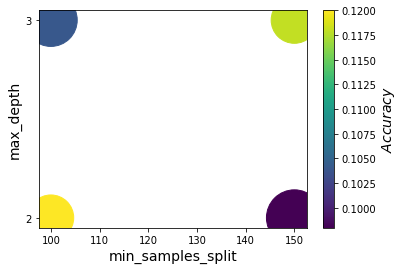

In [68]:
# cross-validation

model_params['CV'] = True
best_params_CV = main()


In [69]:
# final test

#X_train, y_train, X_valid, y_valid, X_test, y_test = dataset
X_train, y_train, X_valid, y_valid, X_test, y_test = get_data(train_size=500, valid_size=50, test_size=50)

# validation
model = RandomForest(n_trees=2, min_samples_split=best_params_V['param_1'], max_depth=best_params_V['param_2'], n_feats=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')

# cross-validation
model = RandomForest(n_trees=2, min_samples_split=best_params_V['param_1'], max_depth=best_params_V['param_2'], n_feats=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')



 getting dataset... 



In [10]:
# final test

#X_train, y_train, X_valid, y_valid, X_test, y_test = dataset
X_train, y_train, X_valid, y_valid, X_test, y_test = get_data(
    train_size=500, valid_size=50, test_size=50)

# validation
model = RandomForest(
    n_trees=2, min_samples_split=100, max_depth=2, n_feats=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')

# cross-validation
model = RandomForest(
    n_trees=2, min_samples_split=100, max_depth=2, n_feats=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'acc: {accuracy_score(y_test, y_pred)}')



 getting dataset... 

acc: 0.08
acc: 0.12
